# A TUTORIAL ON LINEAR GAUSSIAN STATE SPACE MODELS AND KALMAN FILTERS

by Sebastian T. Glavind, February 2022

In [1]:
import numpy as np
import scipy
import scipy.stats as ss
from scipy.optimize import minimize 
from scipy.integrate import odeint
import sympy
import joblib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
print(np.__version__,', ', scipy.__version__)

1.21.2 ,  1.7.3


# The linear Gaussian state space model

Linear Gaussian state space models, also referred to as dynamic linear models (DLM), defines a 1. order, M-dimensional vector autoregression as the state equation, i.e.,

$$ x_t = \Phi x_{t-1} + w_t, $$

where $x_0 \sim \mathcal{N}(\mu_0, \Sigma_0)$ and $w_t \sim \mathcal{N}(0, Q)$. The state vector $x_t$ is latent, i.e., not observed, but we can observe a noisy, linearly transformed version of it, i.e.,

$$ y_t = A_t x_t + v_t, $$

where $A_t$ is the so-called $K \times M$ measurement or observation matrix - with $K$ being the dimention of the observations - and $v_t \sim \mathcal{N}(0, R)$. A graphical representation of the state space model is shown below.

<!-- ![fig_linearGaussianSSM](Figures/SSM_linearGaussian.png) -->
<img src="Figures/SSM_linearGaussian.png" width="450" height="240" />
<!-- <center><img src="Figures/SSM_linearGaussian.png" width="480" height="240"></center> -->

For further details, the interested reader is referred to Shumway & Stoffer (2017), ch. 6.

# The Kalman filter equations

The prediction equations:

$$ x_t^{t-1} = \Phi x_{t-1}^{t-1}, $$

$$ P_t^{t-1} = \Phi P_{t-1}^{t-1} \Phi' + Q. $$

The filtering equations:

$$ x_t^{t} = x_t^{t-1} + K_t (y_t - A_t x_t^{t-1}), $$

$$ P_t^{t} = ( I - K_t A_t ) P_{t}^{t-1}, $$

where the Kalman gain $K_t$ is defined as

$$ K_t = P_{t}^{t-1} A_t' [ A_t P_{t}^{t-1} A_t' + R ]^{-1}. $$

In the equations above, the subscript refer to the time for which inference is conducted, and the superscript refer to the information avaliable at the time of inference.

At each time step, we may further compute the innovations, i.e.,

$$ \epsilon_t = A_t x_{t}^{t-1}, $$

The innovations form the (log) likelihood of the data $y_{1:T}$ as

$$ - \log L_Y(\Theta) \propto \frac{1}{2} \sum_{t=1}^T \log | \Sigma_t(\Theta) | +  \frac{1}{2} \sum_{t=1}^T \epsilon_t(\Theta)' \Sigma_t(\Theta)^{-1} \epsilon_t(\Theta), $$

where the covariance matrix at each time instance is defined as

$$ \Sigma_t = A_t P_t^{t-1} A_t' + R, $$

and $\Theta$ reflect the parameters of the model. For further details see e.g., Shumway & Stoffer (2017), sec. 6.2.

Below, you see an implementation of the Kalman filter equations, where all model parameters can be provided as input, and thus the function can be used for learning all model parameters. In the following examples we will, however, restrict ourselves to learning $Q$ and $R$ from the data, through their cholesky decompositions. 

***
Shumway, R. H. & Stoffer, D. S. (2017). Time series analysis and its applications, Springer.
*** 

In [3]:
# Kalman filter for state space (displacement, velocity)
# See Shumway & Stoffer (2017), ch. 6.
# https://rdrr.io/cran/astsa/src/R/Kfilter0.R
def myKalmanFiler(y, # data np.array
                  cQ, cR, 
                  mu0 = np.asarray([30,20]), #first estimate 
                  Sigma0 = np.array([[1,0],[0,1]]), 
                  A = np.asarray([[1,0],[0,1]]), #Observation matrix. We want every state from our state vector.
                  Phi = np.array([[1,1],[0,1]]), #Transition matrix. Displacement is updated with prev disp + curr vel while velocity is updated with prev vel (assuming no acc.) 
                  fullOut = 0, # provide denerated quantities as well as predictions/filtering [0 - False; 1 - True]
                 ):
    N, M = y.shape
    Q = cQ @ (cQ.T) # cholesky decomp: cQ=chol(Q), cR=chol(R)
    R = cR @ (cR.T)
    # Initialize
    xp=[] # xp=x_t^{t-1} (prediction) 
    Pp=[] # Pp=P_t^{t-1} (prediction covariance)
    xf=[] # xf=x_t^t (filtering)
    Pf=[] # Pf=x_t^t (filtering covariance)
    innov=[] # innovations
    sig=[] # innov var-cov matrix
    negLogLike=0
    for t in range(N):
        if t==0:
            xp.append( Phi @ mu0 ) # Eq. (6.18)       
            Pp.append( Phi @ Sigma0 @ (Phi.T) + Q ) # Eq. (6.19) 
        else:
            xp.append( Phi @ xf[t-1] ) # Eq. (6.18)  
            Pp.append( Phi @ Pf[t-1] @ (Phi.T) + Q) # Eq. (6.19)  
        
        sigtemp = A @ Pp[t] @ (A.T) + R # Eq. (6.24)  
        sig.append( (sigtemp.T+sigtemp)/2 ) # innov var - make sure it's symmetric
        siginv = np.linalg.inv( sig[t] )              
        K = Pp[t] @ (A.T) @ siginv # Eq. (6.22)  
        innov.append( y[t,] - A @ xp[t] ) # Eq. (6.23)    
        xf.append( xp[t] + K @ innov[t] ) # Eq. (6.20) 
        Pf.append( Pp[t] - K @ A @ Pp[t] )
        negLogLike += np.log(np.linalg.det(sig[t])) + (innov[t].T) @ siginv @ innov[t] # Eq. (6.60)  
    negLogLike *= 0.5 
    
    if (fullOut == 1):
        return(xp, Pp, xf, Pf, negLogLike, K)
    else:
        return(xp, Pp, xf, Pf, negLogLike)

# The Kalman smoothing equations

The smoothing equations:

$$ x_{t-1}^n = x_{t-1}^{t-1} + J_{t-1} (x_t^{n} - x_t^{t-1}), $$

$$ P_{t-1}^n = P_{t-1}^{t-1} + J_{t-1} (P_t^{n} - P_t^{t-1}) J_{t-1}', $$

where 

$$ J_{t-1} = P_{t-1}^{t-1} \Phi' [  P_{t}^{t-1} ]^{-1}. $$

Again, the subscript refer to the time for which inference is conducted, and the superscript refer to the information avaliable at the time of inference, see e.g., Shumway & Stoffer (2017), sec. 6.2.

In [4]:
# Kalman smoother for state space (displacement, velocity)
# See Shumway & Stoffer (2017), ch. 6.
# https://rdrr.io/cran/astsa/src/R/Ksmooth0.R
def myKalmanSmoother(y, # data np.array
                     cQ, cR,
                     mu0 = np.asarray([30,20]), #first estimate 
                     Sigma0 = np.array([[1,0],[0,1]]), 
                     A = np.asarray([[1,0],[0,1]]), #Observation matrix. We want every state from our state vector.
                     Phi = np.array([[1,1],[0,1]]), #Transition matrix. Displacement is updated with prev disp + curr vel while velocity is updated with prev vel (assuming no acc.) 
                     fullOut = 0, # provide denerated quantities as well as predictions/filtering/smoothing
                    ):
    N, M = y.shape
    # Kalman filering
    if (fullOut == 1):
        xp, Pp, xf, Pf, negLogLike, K = myKalmanFiler(y, cQ, cR, mu0, Sigma0, A, Phi, fullOut) # Call to kalman filter function
    else:
        xp, Pp, xf, Pf, negLogLike = myKalmanFiler(y, cQ, cR, mu0, Sigma0, A, Phi) # Call to kalman filter function
    # Kalman smoothing
    xs = [None]*N # xs=x_t^n
    Ps = [None]*N # Ps=P_t^n
    J = [None]*N # J=J_t
    for t in range(N-1,0,-1):
        if t==N-1: # last time step, which is the first iteration
            xs[t] = xf[t] 
            Ps[t] = Pf[t]
        # Kalman smooting equations
        J[t-1] = Pf[t-1] @ (Phi.T) @ np.linalg.inv(Pp[t]) # Eq. (6.47)
        xs[t-1] = xf[t-1] + J[t-1] @ (xs[t] - xp[t]) # Eq. (6.45)
        Ps[t-1] = Pf[t-1] + J[t-1] @ (Ps[t] - Pp[t]) @ (J[t-1].T) # Eq. (6.46)
    
    if (fullOut == 1):
        # First time step
        J0 = Sigma0 @ (Phi.T) @ np.linalg.inv(Pp[0])
        x0n = mu0 + J0 @ (xs[0] - xp[0])
        P0n = Sigma0 + J0 @ (Ps[0] - Pp[0]) @ (J0.T)
        # Output
        return(xp, Pp, xf, Pf, xs, Ps, negLogLike, K, J, J0, x0n, P0n)
    else:
        # Output
        return(xp, Pp, xf, Pf, xs, Ps, negLogLike)

# Numerical examples considering general, single degree of freedom spring systems

## Introduction 

In this notebook, we will study the following forced mass-spring-damper system:

<!-- ![fig_linearGaussianSSM](Figures/SSM_mass_spring_damper_system.png) -->
<img src="Figures/SSM_mass_spring_damper_system.png" width="256" height="240" />
<!-- <center><img src="Figures/SSM_mass_spring_damper_system.png" width="480" height="240"></center> -->

### Continuous system representation

Using Newtons 2. law, i.e., $\sum F = m a$, the system dymanics can be described as

$$ F(t) - c \dot{x}(t) - k x(t) = m \ddot{x}, $$

where $F$ is the external force, $c$ is the damping, $k$ is the spring stifness, and $x$, $\dot{x}$, and $\ddot{x}$ are the position, velocity, and accelaration of the mass.

Higher-order differential equations, like the second-order equation above, can often be rewritten in terms of a system of first-order differential equations, i.e.,

$$
\begin{align}
\dot{x}_1 &= x_2 \\
\dot{x}_2 &= m^{-1} (F - c x_2 - k x_1),
\end{align}
$$

where we have defined $x=x_1$ (position) and $\dot{x}=x_2$ (velocity). Equivalently, the system of first-order differntial equation may also be written in matrix form using the state-space formulation, i.e.,

$$
\begin{align}
\begin{bmatrix}
\dot{x}_1\\
\dot{x}_2
\end{bmatrix}
&=
\begin{bmatrix}
0 & 1\\
- \frac{k}{m} & - \frac{c}{m}
\end{bmatrix}
\begin{bmatrix}
x_1\\
x_2
\end{bmatrix}
+
\begin{bmatrix}
0\\
\frac{1}{m}
\end{bmatrix}
F \\
&=
A \mathbf{x} + B \mathbf{u},
\end{align}
$$

where 

$$ A = \begin{bmatrix} 0 & 1\\ - \frac{k}{m} & - \frac{c}{m} \end{bmatrix}, B = \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix}, \ \text{and} \quad \mathbf{x} = \begin{bmatrix} x_1 \\ x_2 \end{bmatrix}$$

### Discrete system representation

For numerical simulations, it may further be convenient to discretize a continuous system. By use of Eulers forward method, we can approximate the derivatives above as

$$ \dot{x} \approx \frac{x(s+1)-x(s)}{\Delta t}, $$

where $x(s)$ is the value of $x$ at discrete time step $s$, and $\Delta t$ is the discrete step size. Thus, we can approximate our differential equations above as 

$$
\begin{align}
\frac{x_1(s+1)-x_1(s)}{\Delta t} &= x_2(s) \\
\frac{x_2(s+1)-x_2(s)}{\Delta t} &= m^{-1} (F(s) - c x_2(s) - k x_1(s)),
\end{align}
$$

which can be rearranged to the following differential equations:

$$
\begin{align}
x_1(s+1) &= x_1(s) + \Delta t x_2(s) \\
x_2(s+1) &= x_2(s) + \Delta t m^{-1} (F(s) - c x_2(s) - k x_1(s)) = - \Delta t \frac{k}{m} x_1(s) + (1 - \Delta t \frac{c}{m}) x_k + \Delta t \frac{1}{m} F(t).
\end{align}
$$

As for the continious case, the equations can also be represented using the (descrete) state-space formulation:

$$
\begin{align}
\begin{bmatrix}
\dot{x}_1(s+1)\\
\dot{x}_2(s+1)
\end{bmatrix}
&=
\begin{bmatrix}
1 & \Delta t\\
- \Delta t \frac{k}{m} & 1 - \Delta t \frac{c}{m}
\end{bmatrix}
\begin{bmatrix}
x_1(s)\\
x_2(s)
\end{bmatrix}
+
\begin{bmatrix}
0\\
\Delta t \frac{1}{m}
\end{bmatrix}
F(s) \\
&=
A_d \mathbf{x}(s) + B_d \mathbf{u},
\end{align}
$$

where 

$$ A_d = \begin{bmatrix} 1 & \Delta t\\ - \Delta t \frac{k}{m} & 1 - \Delta t \frac{c}{m} \end{bmatrix}, 
B_d = \begin{bmatrix} 0\\ \Delta t \frac{1}{m} \end{bmatrix} \ \text{and} \quad 
\mathbf{x}(s) = \begin{bmatrix} x_1(s) \\ x_2(s) \end{bmatrix}$$

For further details see e.g., Halvorsen (2020).

## Kalman filter for the considered system

In the numerical examples, we will assume that we only observe noisy accelarations from the system, and we want to estimate the latent system dynamics in terms of accelarations, velocities, and displacements. Thus, $y_t$ holds the noisy accelaration signal at time $t$, the observation matrix $A_t = [ 0, 0, 1 ]$, which maps between latent and observed space. Furthermore, the state transition matrix is defined as

$$
\Phi =
\begin{bmatrix}
1 & \Delta t & 0.5 \Delta t^2\\
0 & 1 & \Delta t\\
0 & 0 & 1
\end{bmatrix},
$$

which thus defines the state space beased on the observed infromation, i.e., the matrix will enable integration of the accelerations to velocities and displacements, see Labbe (2020), sec. 8.3.3. This state-transition matrix appear as a direct consquense of representing Newtons equations of motion using the state-space model. 

***
Halvorsen, H-P (2020), Python for Control Engineering ([link 1](https://www.halvorsen.blog/documents/programming/python/resources/Python%20for%20Control%20Engineering.pdf); [link 2](https://www.halvorsen.blog/documents/programming/python/resources/powerpoints/Mass-Spring-Damper%20System%20with%20Python.pdf))

Labbe, R. R. (2020), Kalman and Bayesian Filters in Python ([link 1](https://drive.google.com/file/d/0By_SW19c1BfhSVFzNHc0SjduNzg/view?resourcekey=0-41olC9ht9xE3wQe2zHZ45A); [link 2](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python))
***

## Example 1: Constant forcing

### Using scipy.integrate to solve the ODE system

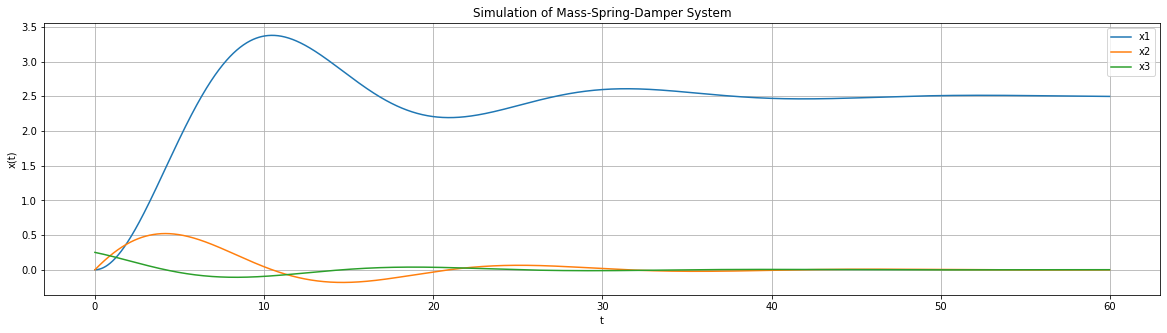

In [5]:
# https://www.halvorsen.blog/documents/programming/python/resources/powerpoints/Mass-Spring-Damper%20System%20with%20Python.pdf
# Initialization
tstart = 0
tstop = 60
dt = 0.025
# dt = 0.05
# Initial condition
x_init = [0.,0.]
time = np.arange(tstart, tstop, dt)

# Function that returns dx/dt
def mySpring1(x, t):
    c = 4 # Damping constant
    k = 2 # Stiffness of the spring
    m = 20 # Mass
    F = 5 # force
    dx1dt = x[1]
    dx2dt = (F - c*x[1] - k*x[0])/m
    dxdt = [dx1dt, dx2dt]
    return dxdt

def myAcc1(x):
    c = 4 # Damping constant
    k = 2 # Stiffness of the spring
    m = 20 # Mass
    F = 5 # force
    acc = (F - c*x[:,1] - k*x[:,0])/m
    return(acc)

# Solve ODE
xsolve1a = odeint(mySpring1, x_init, time)
x11a = xsolve1a[:,0]
x12a = xsolve1a[:,1]
x13a = myAcc1(xsolve1a)

# Plot the Results
plt.figure(figsize=(20,5))
plt.plot(time,x11a)
plt.plot(time,x12a)
plt.plot(time,x13a)
plt.title('Simulation of Mass-Spring-Damper System')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.legend(["x1", "x2", "x3"])
plt.grid()
plt.show()

### Using discrete (deterministic) simulations to solve the ODE system

In [6]:
# https://www.halvorsen.blog/documents/programming/python/resources/powerpoints/Mass-Spring-Damper%20System%20with%20Python.pdf
def myDiscSpringSim1(x_init, dt, N):
    c = 4 # Damping constant
    k = 2 # Stiffness of the spring
    m = 20 # Mass
    F = 5 # force

    xl = []; xl.append(np.array(x_init).reshape(-1,1)) # Initial Position
    A = np.array( [ [1, dt], [-(dt*k)/m, 1 - (dt*c)/m] ] )  
    B = np.array( [ [0], [dt/m] ] )

    # Simulation
    for s in range(N):
        xl.append( A @ xl[s] + B * F ) # x[s+1]
    xm = np.hstack(xl).T
    
    return(xm)

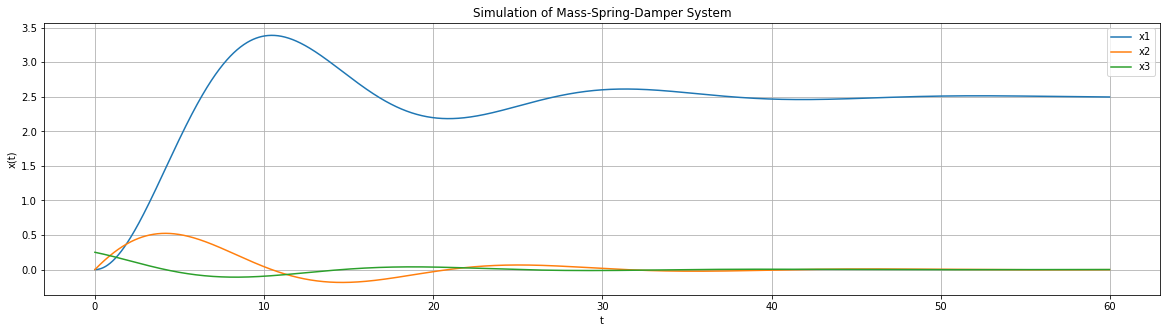

In [7]:
# Solve ODE
N = int((tstop-tstart)//dt) # Simulation length
xsolve1b = myDiscSpringSim1(x_init, dt, N)
x11b = xsolve1b[:,0]
x12b = xsolve1b[:,1]
x13b = myAcc1(xsolve1b)

# Plot the Results
plt.figure(figsize=(20,5))
plt.plot(time,x11b)
plt.plot(time,x12b)
plt.plot(time,x13b)
plt.title('Simulation of Mass-Spring-Damper System')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.legend(["x1", "x2", "x3"])
plt.grid()
plt.show()

In [8]:
# # test that veloceties can be reproduced from accelerations
# test=[]; test.append(0.)
# for i in range(len(x13b)-1):
#         test.append( test[i] + dt*x13b[i] )
#         # Plot the Results
# plt.plot(time,x12b)
# plt.plot(time,test, 'r.')
# plt.title('Simulation of Mass-Spring-Damper System')
# plt.xlabel('t')
# plt.ylabel('x(t)')
# plt.grid()
# plt.show()

### Noisy observations from accelerometers

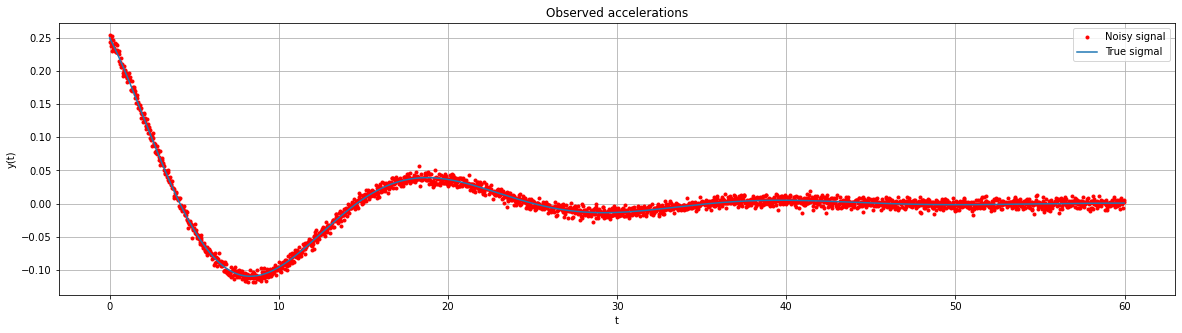

In [9]:
np.random.seed(123)
sig_noise = np.std(x13b)*0.1
var_noise = sig_noise**2
y1 = x13b + np.random.normal(size=len(x13b)) * sig_noise

# Plot the Results
plt.figure(figsize=(20,5))
plt.plot(time,y1, 'r.', label='Noisy signal')
plt.plot(time,x13b, label='True sigmal')
plt.title('Observed accelerations')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend()
plt.grid()
plt.show()

### Some basic forms for Q

In [10]:
# Labbe (2020), sec. 7.3.1 (spectral density is a fitting constant)
# (called Q_continuous_white_noise in package filterpy, see below)
from filterpy.common import Q_continuous_white_noise # Labbe (2020), sec. 7.3.1 (spectral density is a fitting constant)
Qbase_a = Q_continuous_white_noise(dim=3, dt=dt, spectral_density = 1) # Labbe (2020), sec. 7.3.1 (spectral density is a fitting constant)

# Deriving formula
sympy.init_printing(use_latex='mathjax')
dt_, phi_ = sympy.symbols('\Delta{t} \Phi_s')
F_k_ = sympy.Matrix([[1, dt_, dt_**2/2], [0, 1, dt_], [0, 0, 1]])
Q_c_ = sympy.Matrix([[0, 0, 0], [0, 0, 0], [0, 0, 1]])*phi_
Q_ = sympy.integrate(F_k_ * Q_c_ * F_k_.T, (dt_, 0, dt_))
# factor phi out of the matrix to make it more readable
Q_ = Q_ / phi_
sympy.MatMul(Q_, phi_)

⎡         5           4           3⎤      
⎢\Delta{t}   \Delta{t}   \Delta{t} ⎥      
⎢──────────  ──────────  ──────────⎥      
⎢    20          8           6     ⎥      
⎢                                  ⎥      
⎢         4           3           2⎥      
⎢\Delta{t}   \Delta{t}   \Delta{t} ⎥      
⎢──────────  ──────────  ──────────⎥⋅\Phiₛ
⎢    8           3           2     ⎥      
⎢                                  ⎥      
⎢         3           2            ⎥      
⎢\Delta{t}   \Delta{t}             ⎥      
⎢──────────  ──────────  \Delta{t} ⎥      
⎣    6           2                 ⎦      

In [11]:
# Labbe (2020), sec. 7.3.2 (variance is a fitting constant)
# (called Q_discrete_white_noise in package filterpy, see below)
from filterpy.common import Q_discrete_white_noise
Qbase_b = Q_discrete_white_noise(dim=3, dt=dt, var = 1) # Labbe (2020), sec. 7.3.2 (variance is a fitting constant)

# Deriving formula
var_ = sympy.symbols('sigma^2')
v_ = sympy.Matrix([[dt_**2 / 2], [dt_], [1]])
Q_ = v_ * var_ * v_.T
# factor variance out of the matrix to make it more readable
Q_ = Q_ / var_
sympy.MatMul(Q_, var_)

⎡         4           3           2⎤   
⎢\Delta{t}   \Delta{t}   \Delta{t} ⎥   
⎢──────────  ──────────  ──────────⎥   
⎢    4           2           2     ⎥   
⎢                                  ⎥   
⎢         3                        ⎥   
⎢\Delta{t}            2            ⎥   
⎢──────────  \Delta{t}   \Delta{t} ⎥⋅σ²
⎢    2                             ⎥   
⎢                                  ⎥   
⎢         2                        ⎥   
⎢\Delta{t}                         ⎥   
⎢──────────  \Delta{t}       1     ⎥   
⎣    2                             ⎦   

In [12]:
# Labbe (2020), sec. 7.3.4 (variance is a fitting constant)
Qbase_c = np.diag([0., 0., 1.]) # Labbe (2020), sec. 7.3.4 (variance is a fitting constant)

# Fomula
sympy.MatMul(sympy.Matrix([[0, 0, 0], [0, 0, 0], [0, 0, 1]]), var_)

⎡0  0  0⎤   
⎢       ⎥   
⎢0  0  0⎥⋅σ²
⎢       ⎥   
⎣0  0  1⎦   

### Kalman filtering 

In [13]:
# System:
# https://stackoverflow.com/questions/47210512/using-pykalman-on-raw-acceleration-data-to-calculate-position
Phi = np.array([ [1, dt, 0.5*dt**2], [0, 1, dt], [0, 0, 1] ])
A = np.array([[ 0, 0, 1 ]])

# Initialization, see Labbe (2020), sec.6.15
# mu0 = np.array([0., 0., y1[0]]).reshape(-1,1)
mu0 = np.linalg.pinv(A) @ np.array([[ y1[0] ]]) # inversion from first measurement (gives the same as above)
Sigma0 = np.eye(3) * np.array([var_noise , var_noise, var_noise]) # approx. max(pos, vel)^2 (at steady state) and acc. noise variance
Qtest = Qbase_a * (1e-4) # Labbe (2020), sec. 7.3.1 (spectral density is a fitting constant)
# Qtest = Qbase_b * (var_noise) + np.eye(3)*1e-8 # Labbe (2020), sec. 7.3.2 (variance is a fitting constant)
# Qtest = Qbase_c * (var_noise) + np.eye(3)*1e-8 # Labbe (2020), sec. 7.3.4 (variance is a fitting constant)
# Qtest = np.diag([var_noise*1e-6, var_noise*1e-4, var_noise]) # + np.eye(3)*1e-8 # Perris et al (2009), sec. 4.5.1 (DIG)
cQtest = np.linalg.cholesky(Qtest)

In [14]:
xp1, Pp1, xf1, Pf1, xs1, Ps1, negLogLike1 = myKalmanSmoother(y=y1.reshape(-1,1),
                                                             cQ=cQtest, cR=np.array([sig_noise]).reshape(-1,1),  
                                                             mu0 = mu0, Sigma0 = Sigma0, 
                                                             A = A, Phi = Phi )

xp1 = np.array(xp1); Pp1 = np.array(Pp1)
xf1 = np.array(xf1); Pf1 = np.array(Pf1)
xs1 = np.array(xs1); Ps1 = np.array(Ps1)

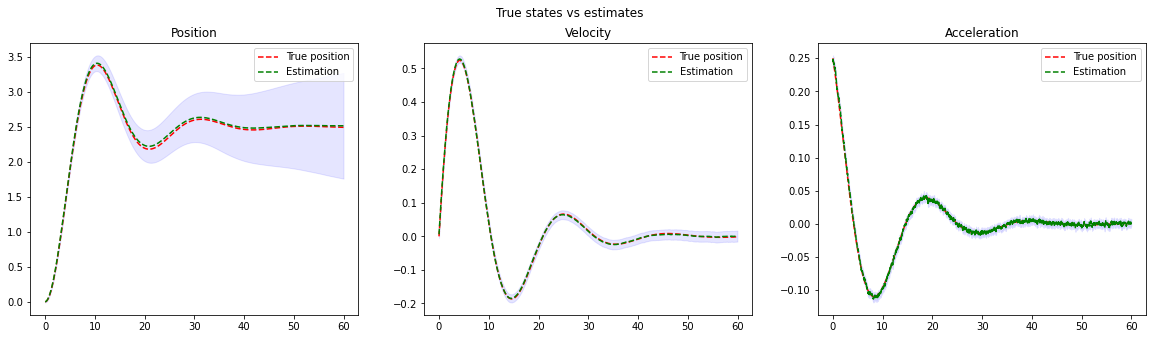

In [15]:
def plot_kf_estimation(x1,x2,x3,xf,Pf,dt):
    nt = xf.shape[0]
    xax = np.arange(0,nt,1)*dt
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
    fig.suptitle('True states vs estimates')
    
    ax1.plot(xax, x1, 'r--', label='True position')
    ax1.plot(xax, xf[:,0,0], 'g--', label='Estimation')
    ax1.fill_between(x=xax, y1=xf[:,0,0]-2*np.sqrt(Pf[:,0,0]), y2=xf[:,0,0]+2*np.sqrt(Pf[:,0,0]), alpha=0.1, color='blue');
    ax1.set_title("Position")
    ax1.legend(loc='upper right')

    ax2.plot(xax, x2, 'r--', label='True position')
    ax2.plot(xax, xf[:,1,0], 'g--', label='Estimation')
    ax2.fill_between(x=xax, y1=xf[:,1,0]-2*np.sqrt(Pf[:,1,1]), y2=xf[:,1,0]+2*np.sqrt(Pf[:,1,1]), alpha=0.1, color='blue');
    ax2.set_title("Velocity")
    ax2.legend(loc='upper right')

    ax3.plot(xax, x3, 'r--', label='True position')
    ax3.plot(xax, xf[:,2,0], 'g--', label='Estimation')
    ax3.fill_between(x=xax, y1=xf[:,2,0]-2*np.sqrt(Pf[:,2,2]), y2=xf[:,2,0]+2*np.sqrt(Pf[:,2,2]), alpha=0.1, color='blue');
    ax3.set_title("Acceleration")
    ax3.legend(loc='upper right')

    plt.show()
    
plot_kf_estimation(x11b,x12b,x13b,xf1,Pf1,dt)

## Example 2: Variable forcing

### Using discrete (deterministic) simulations to solve the ODE system

In [16]:
# https://www.halvorsen.blog/documents/programming/python/resources/powerpoints/Mass-Spring-Damper%20System%20with%20Python.pdf
def myDiscSpringSim2(x_init, dt, N, F):
    c = 4 # Damping constant
    k = 2 # Stiffness of the spring
    m = 20 # Mass

    xl = []; xl.append(np.array(x_init).reshape(-1,1)) # Initial Position
    A = np.array( [ [1, dt], [-(dt*k)/m, 1 - (dt*c)/m] ] )  
    B = np.array( [ [0], [dt/m] ] )

    # Simulation
    for s in range(N):
        xl.append( A @ xl[s] + B * F[s] ) # x[s+1]
    xm = np.hstack(xl).T
    
    return(xm)

def myAcc2(x, F):
    c = 4 # Damping constant
    k = 2 # Stiffness of the spring
    m = 20 # Mass
    acc = (F - c*x[:,1] - k*x[:,0])/m
    return(acc)

# Force modeling

# AR
# def myForceSim(N,seed):
#     # AR(2)
#     np.random.seed(seed)
#     w = np.random.normal(size=N)*0.1
#     f = np.zeros(N); f[0] = w[0]
#     for t in range(3,N):
#         f[t] = 0.9*f[t-1] + 0.1*f[t-2] + w[t]
        
#     return(f)

# GP
def se_kern(x, y, sig_f, l_f): # Kernel function: Squared exponential (SE)
    sqdist = np.sum(x**2,1).reshape(-1,1) + np.sum(y**2,1) - 2*np.dot(x, y.T) # reshape(-1,1): from one-dim. to two-dim. array.
    K = sig_f**2 * np.exp( -0.5 * sqdist / (l_f**2) )
    return(K)

def myForceSim(tvec, sig_f, l_f, seed):
    N = tvec.shape[0]
    # GP
    np.random.seed(seed)
    # Kernel function
    K = se_kern(tvec, tvec, sig_f, l_f)
    # Get cholesky decomposition (square root) of the covariance matrix
    eps=1e-8
    L = np.linalg.cholesky(K + eps*np.eye(N)) # add a litte jitter for numerical stability
    # Sample 3 sets of standard normals for our test points, multiply them by the square root of the covariance matrix
    f = np.dot(L, np.random.normal(size=(N,1)))

    return(f)

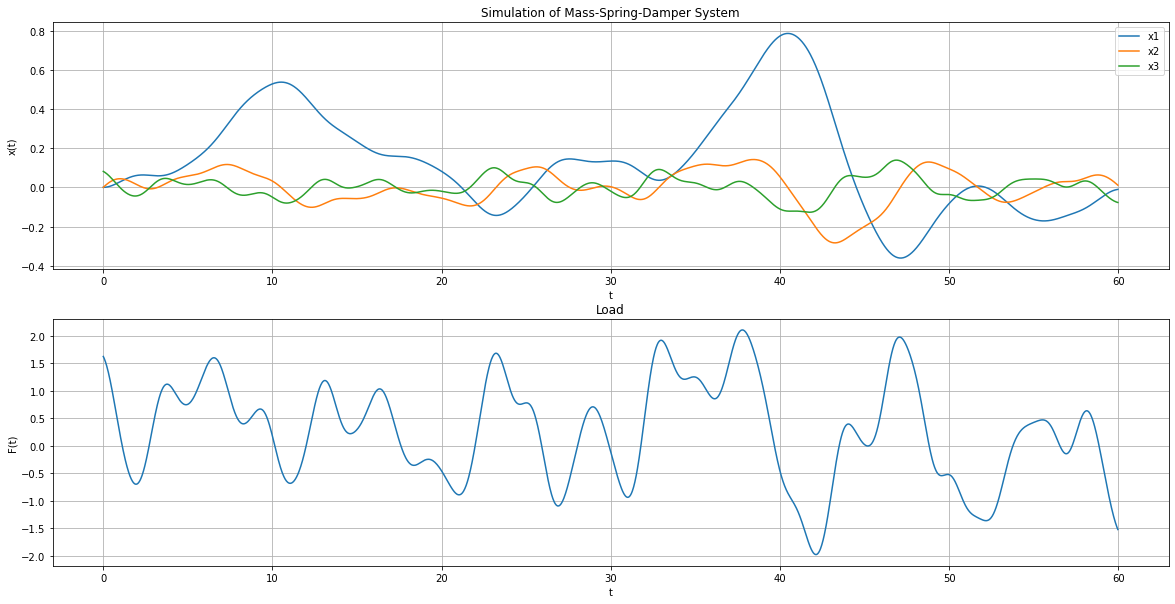

In [17]:
# Solve ODE
# Ft = myForceSim(N=N+1,seed=1)
Ft = myForceSim(tvec=time.reshape(-1,1), sig_f=1, l_f=1, seed=1).flatten()
xsolve2 = myDiscSpringSim2(x_init, dt, N, Ft)
x21 = xsolve2[:,0]
x22 = xsolve2[:,1]
x23 = myAcc2(xsolve2, Ft)

# Plot the Results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10))

ax1.plot(time,x21)
ax1.plot(time,x22)
ax1.plot(time,x23)
ax1.set_title('Simulation of Mass-Spring-Damper System')
ax1.set_xlabel('t')
ax1.set_ylabel('x(t)')
ax1.legend(["x1", "x2", "x3"])
ax1.grid()

ax2.plot(time,Ft)
ax2.set_title('Load')
ax2.set_xlabel('t')
ax2.set_ylabel('F(t)')
ax2.grid()

plt.show()

In [18]:
# # test that veloceties can be reproduced from accelerations
# test=[]; test.append(0.)
# for i in range(len(x23)-1):
#         test.append( test[i] + dt*x23[i] )
#         # Plot the Results
# plt.plot(time,x22)
# plt.plot(time,test, 'r--')
# # plt.plot(time,test-x22); plt.ylim([-1e-8,1e-8])
# plt.title('Simulation of Mass-Spring-Damper System')
# plt.xlabel('t')
# plt.ylabel('x(t)')
# plt.grid()
# plt.show()

### Noisy observations from accelerometers

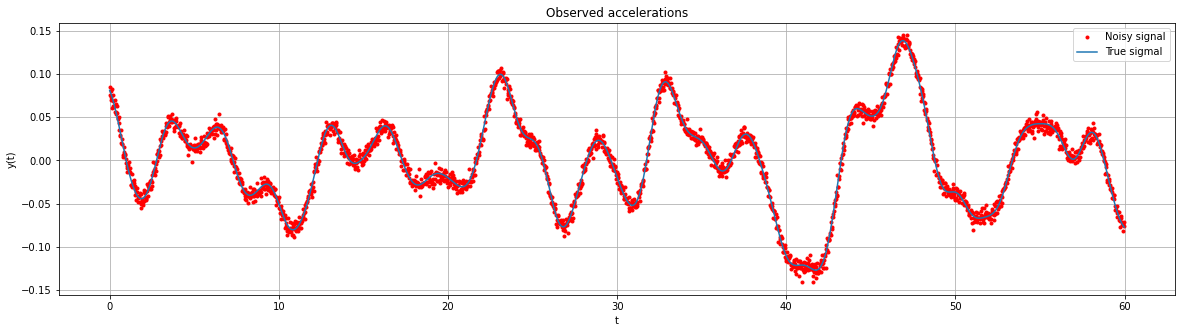

In [19]:
np.random.seed(123)
sig_noise2 = np.std(x23)*0.1
var_noise2 = sig_noise2**2
y2 = x23 + np.random.normal(size=len(x23)) * sig_noise2

# np.savetxt('spring_data_v4.csv', [y2, x21, x22, x23], delimiter=',')

# Plot the Results
plt.figure(figsize=(20,5))
plt.plot(time,y2, 'r.', label='Noisy signal')
plt.plot(time,x23, label='True sigmal')
plt.title('Observed accelerations')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend()
plt.grid()
plt.show()

### Kalman filtering 

In [20]:
# https://stackoverflow.com/questions/47210512/using-pykalman-on-raw-acceleration-data-to-calculate-position
mu02 = np.linalg.pinv(A) @ np.array([[ y2[0] ]]) # inversion from first measurement (gives the same as above)
Sigma02 = np.eye(3) * np.array([0.25**2 , var_noise2, var_noise2]) # approx. max(pos, vel)^2 (at steady state) and acc. noise variance
# Qtest2 = Qbase_a * (1e-2) # Labbe (2020), sec. 7.3.1 (spectral density is a fitting constant)
# Qtest2 = Qbase_b * (var_noise2) + np.eye(3)*1e-8 # Labbe (2020), sec. 7.3.2 (variance is a fitting constant)
# Qtest2 = Qbase_c * (var_noise2) + np.eye(3)*1e-8 # Labbe (2020), sec. 7.3.4 (variance is a fitting constant)
Qtest2 = np.diag([var_noise2*1e-6, var_noise2*1e-4, var_noise2]) # + np.eye(3)*1e-8 # Perris et al (2009), sec. 4.5.1 (DIG)
cQtest2 = np.linalg.cholesky(Qtest2)

In [21]:
xp2, Pp2, xf2, Pf2, xs2, Ps2, negLogLike2 = myKalmanSmoother(y=y2.reshape(-1,1),
                                                             cQ=cQtest2, cR=np.array([sig_noise2]).reshape(-1,1),  
                                                             mu0 = mu02, Sigma0 = Sigma02, 
                                                             A = A, Phi = Phi )

xp2 = np.array(xp2); Pp2 = np.array(Pp2)
xf2 = np.array(xf2); Pf2 = np.array(Pf2)
xs2 = np.array(xs2); Ps2 = np.array(Ps2)
print(negLogLike2)

[[-10753.05301727]]


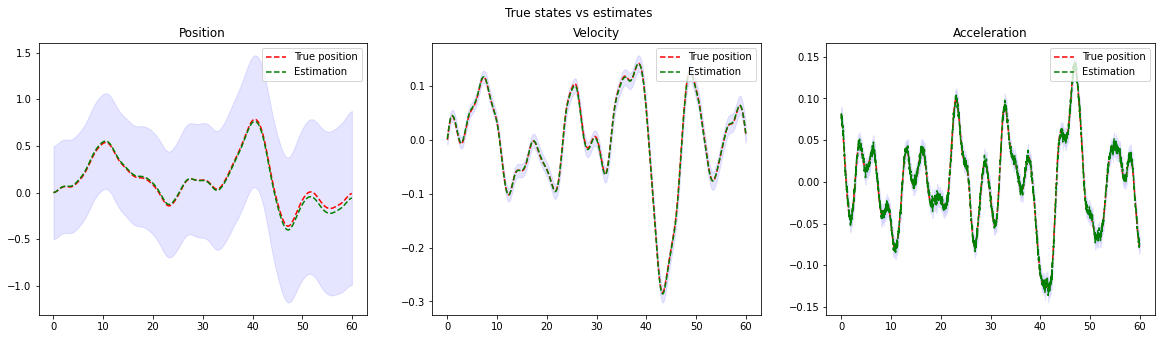

In [22]:
plot_kf_estimation(x21,x22,x23,xf2,Pf2,dt)

### Test filtering against filterpy.kalman.KalmanFilter 

In [23]:
from filterpy.kalman import KalmanFilter

def pos_filterpy(x, P=Sigma02, R=np.array([[var_noise2]]), Q=Qtest2):
    kf = KalmanFilter(dim_x=3, dim_z=1)
    kf.x = np.array([x[0], x[1], x[2]]).reshape(-1,1) # location and velocity
    kf.F = Phi # state transition matrix
    kf.H = A # Measurement function
    kf.R = R # measurement uncertainty
    kf.P[:] = P
    kf.Q[:] = Q
    return kf

def run_pos_filterpy(zs, x0=np.array([0., 0., 0.])):
    # create the Kalman filter
    kf = pos_filterpy(x0)
    # run the kalman filter and store the results
    xs, cov = [], []
    for z in zs:
        kf.predict()
        kf.update(z)
        xs.append(kf.x)
        cov.append(kf.P)
    xs, cov = np.array(xs), np.array(cov)
    
    return xs, cov

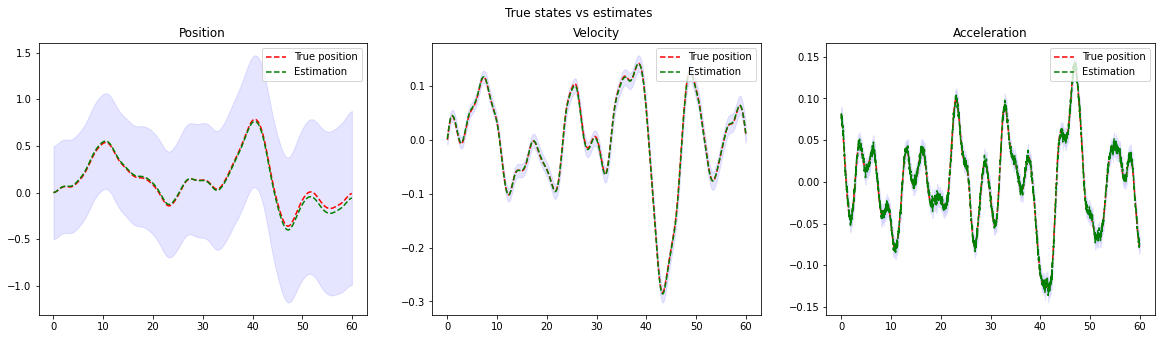

In [24]:
xf_fpy, Pf_fpy = run_pos_filterpy(y2, x0=mu02)

plot_kf_estimation(x21,x22,x23,xf_fpy,Pf_fpy,dt)

### Parameter learning using the Nelder-Mead algorithm 

#### Objective  

In [25]:
# Want to minimize objective
def negLogLikeObj(para):
    if (len(para)==1):
        # Q = Qbase_a * np.exp(para[0]) # Labbe (2020), sec. 7.3.1 (spectral density is a fitting constant)
        # Q = Qbase_b * np.exp(para[0]) + np.eye(3)*1e-8 # Labbe (2020), sec. 7.3.2 (variance is a fitting constant)
        Q = Qbase_c * np.exp(para[0]) + np.eye(3)*1e-8 # Labbe (2020), sec. 7.3.4 (variance is a fitting constant)
    else:
        Q = np.diag(np.exp(para)) + np.eye(3)*1e-8 # Perris et al (2009), sec. 4.5.1 (DIG)
    cQ = np.linalg.cholesky(Q)
    _, _, _, _, obj = myKalmanFiler(y=y2.reshape(-1,1), 
                                    cQ=cQ, cR=np.array([sig_noise2]).reshape(-1,1), 
                                    mu0 = mu02, Sigma0 = Sigma02, 
                                    A = A, Phi = Phi ) 
    
    return(obj[0,0])

#### Optimization

In [26]:
# para_opt = minimize(fun=negLogLikeObj, x0 = [np.log(var_noise2)], method='Nelder-Mead') # one-parameter version
para_opt = minimize(fun=negLogLikeObj, x0 = [np.log(var_noise2*1e-6), np.log(var_noise2*1e-4), np.log(var_noise2)], method='Nelder-Mead') # three-parameter version
para_opt

 final_simplex: (array([[-23.13057012, -18.81454048, -11.54475569],
       [-23.13062843, -18.81451484, -11.54473979],
       [-23.13053134, -18.81451852, -11.54473477],
       [-23.13061075, -18.81446526, -11.54476127]]), array([-10892.99338202, -10892.99338202, -10892.993382  , -10892.993382  ]))
           fun: -10892.993382017103
       message: 'Optimization terminated successfully.'
          nfev: 96
           nit: 48
        status: 0
       success: True
             x: array([-23.13057012, -18.81454048, -11.54475569])

In [27]:
# # Parallel implementation
# # https://github.com/yngvem/parallelising-python
# np.random.seed(111)
# para_list = [ [np.log(var_noise2), np.log(0.25**2), np.log(var_noise2)]]
# para_list.append( [np.log(var_noise2 * 100), np.log(1**2), np.log(var_noise2*0.1)] )
# for i in range(5):
#     para_list.append( [np.random.uniform(-10., 2.),
#                        np.random.uniform(-15., 1.), 
#                        np.random.uniform(-15., -5.)] )
# def run_loc_opt(para):
#     para_opt = minimize(fun=negLogLikeObj, x0 = para, method='Nelder-Mead')
#     return(para_opt)

# para_opt_list = joblib.Parallel(n_jobs=-2)(joblib.delayed(run_loc_opt)(x) for x in para_list)

# obj_opt_list = []
# for i in range(len(para_opt_list)):
#     obj_opt_list.append( para_opt_list[0].fun )
# para_opt = para_opt_list[np.argmin(obj_opt_list)]

In [28]:
# Qopt = Qbase_c * np.exp(para_opt.x[0]) + np.eye(3)*1e-8 # one-parameter version
Qopt = np.diag(np.exp(para_opt.x)) + np.eye(3)*1e-8 # three-parameter version
cQopt =  np.linalg.cholesky(Qopt)
_, _, xf_opt, Pf_opt, negLogLike_opt = myKalmanFiler(y=y2.reshape(-1,1),
                                                     cQ=cQopt, cR=np.array([sig_noise2]).reshape(-1,1),
                                                     mu0 = mu02, Sigma0 = Sigma02,
                                                     A = A, Phi = Phi )

xf_opt = np.array(xf_opt); Pf_opt = np.array(Pf_opt)
print(negLogLike_opt)

[[-10892.99338202]]


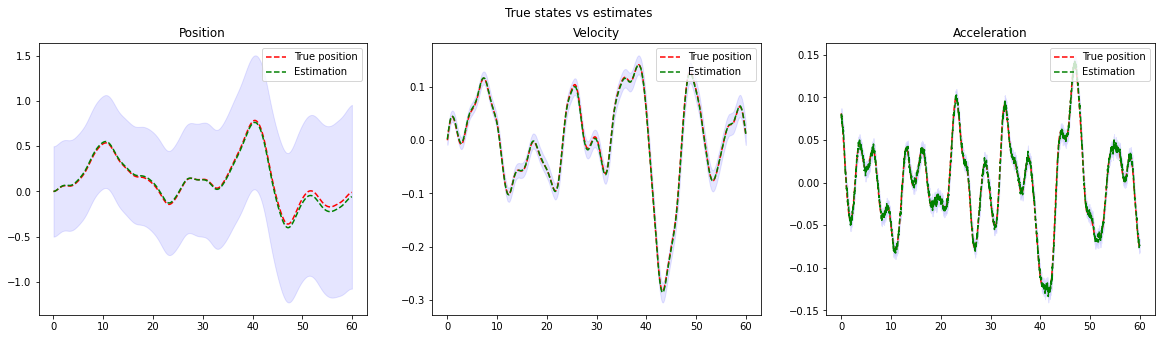

In [29]:
plot_kf_estimation(x21,x22,x23,xf_opt,Pf_opt,dt)

### Parameter learning using Bayesian inference

#### Gibbs sampling using forward filtering backward sampling 

See Shumway & Stoffer (2017; ch. 6) and Petris et al (2009; ch. 4) for a reference on forward filtering, backward sampling for Bayesian inference, and Gelman et al (2013; ch. 11-12) for a general reference on the Markov chain Monte Carlo algorithms.

***
Shumway, R. H. & Stoffer, D. S. (2017). Time series analysis and its applications, Springer.

Gelman, Andrew, et al. (2013), Bayesian data analysis. CRC press.

Petris, G., Petrone, S. & Campagnoli, P. (2009). Dynamic linear models with R. Springer.
***

In [30]:
# Forward filtering, backward samping of state space (displacement, velocity)
# See Shumway & Stoffer (2017), ch. 6. (sec. 6.12; forward filtering backward sampling)
# See also Petris et al (2009), ch. 4. (sec. 4.4; FFBS)
# https://github.com/cran/dlm/blob/master/R/DLM.R
def myFFBS(y, # data np.array
           cQ, cR,
           mu0 = np.asarray([30,20]), #first estimate 
           Sigma0 = np.array([[1,0],[0,1]]), 
           A = np.asarray([[1,0],[0,1]]), #Observation matrix. We want every state from our state vector.
           Phi = np.array([[1,1],[0,1]]), #Transition matrix. Displacement is updated with prev disp + curr vel while velocity is updated with prev vel (assuming no acc.) 
          ):
    N, M = y.shape
    D = mu0.shape[0]
    # Kalman filering
    xp, Pp, xf, Pf, _ = myKalmanFiler(y, cQ, cR, mu0, Sigma0, A, Phi) # Call to kalman filter function
    # Backward sampling
    xb = [None]*N # xb=x_t^n
    jitter = np.eye(D) * 1e-8
    for t in range(N-1,0,-1):
        if t==N-1: # last time step, which is the first iteration
            xb[t] = xf[t] + np.linalg.cholesky(Pf[t] + jitter) @ np.random.normal(size=(D,1))
        # Backward filtering equations (note that t-1 corr. to t in Eq. 6.218)
        Jt = Pf[t-1] @ (Phi.T) @ np.linalg.inv(Pp[t]) # Eq. (6.47)
        mt = xf[t-1] + Jt @ (xb[t] - xp[t]) # Eq. (6.218 (and 6.45))
        Vt = Pf[t-1] - Jt @ Pp[t] @ (Jt.T) # Eq. (6.218 (and 6.46))  
        xb[t-1] = mt + np.linalg.cholesky(Vt + jitter) @ np.random.normal(size=(D,1))
        
    return(xb)

#### Initial model

In [31]:
cQinit =  np.diag([sig_noise2*1e-3, sig_noise2*1e-2, sig_noise2])
# cQinit = np.diag(np.array([0.00090131, 0.00092389, 0.00092494])**0.5)
_, _, xf_init, Pf_init, negLogLike_init = myKalmanFiler(y=y2.reshape(-1,1),
                                                        cQ=cQinit, cR=np.array([sig_noise2]).reshape(-1,1),
                                                        mu0 = mu02, Sigma0 = Sigma02,
                                                        A = A, Phi = Phi )

xf_init = np.array(xf_init); Pf_init = np.array(Pf_init)
print(negLogLike_init)

[[-10753.05301727]]


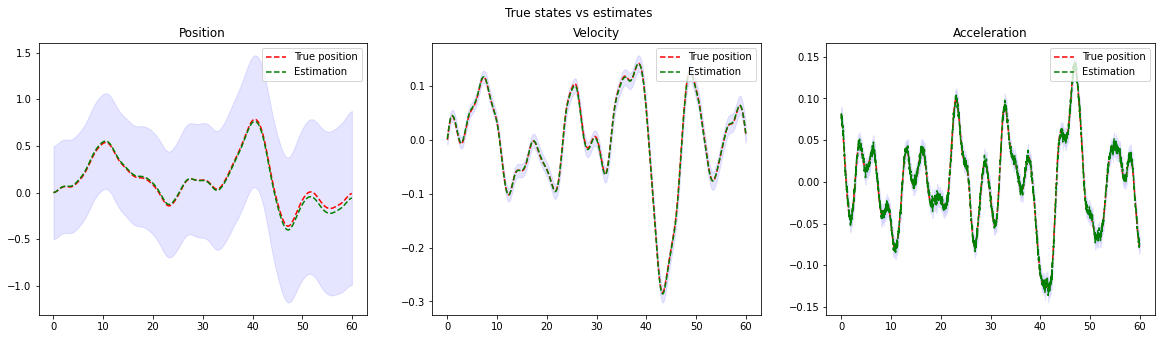

In [32]:
plot_kf_estimation(x21,x22,x23,xf_init,Pf_init,dt)

#### Forward filtering, backward sampling

In [33]:
np.random.seed(1)

collector=[]
for i in range(10):
    xb_test = myFFBS(y=y2.reshape(-1,1), cQ=cQinit, cR=np.array([sig_noise2]).reshape(-1,1),
                                mu0 = mu02, Sigma0 = Sigma02, A = A, Phi = Phi )
    xb_test = np.array(xb_test)
    collector.append(xb_test)

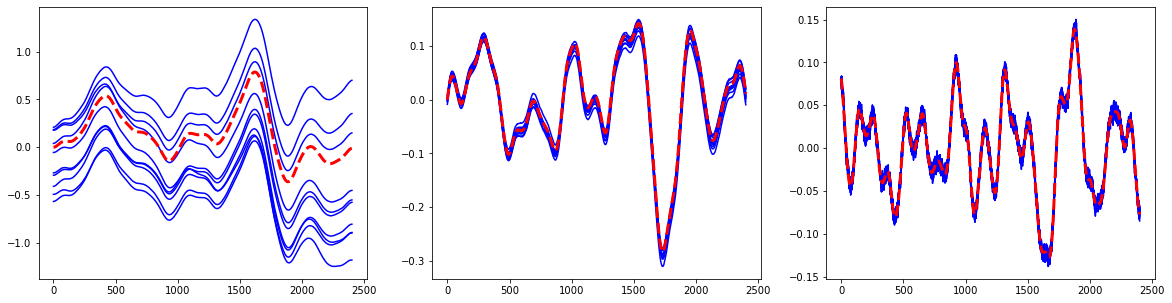

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

for col in collector:
    ax1.plot(col[:,0,0], '-b')
    ax2.plot(col[:,1,0], '-b')
    ax3.plot(col[:,2,0], '-b')

ax1.plot(x21,'--r', linewidth=3)
ax2.plot(x22,'--r', linewidth=3)
ax3.plot(x23,'--r', linewidth=3)

plt.show()

#### Forward filtering, backward sampling meets Gibbs on parameters

We take basis in the joint posterior for the latent state variables and parameters, i.e.,

$$
p(x_{0:T}, \theta | y_{1:T}) = p(x_{0:T} | \theta, y_{1:T}) p(\theta | y_{1:T})
$$

In the following, we show how Markov chain Monte Carlo (MCMC) inference, and in particilar Gibbs sampling, can be used to approximate this posterior distribution.

The general procedure is:

* Initialize: $\theta=\theta^{(0)}$

* For s = 1,..., S
    * Draw $x_{0:T}^{(i)}$ form $p(x_{0:T} | \theta^{(i-1)}, y_{1:T})$ using the forward filtering, backward sampling (FFBS) algorithm 
    * Draw $\theta^{(i)}$ form $p(\theta | y_{1:T}, x_{0:T}^{(i)}).$
    
See Petris et al (2009; sec. 4.4) for further details.

#### Gibbs sampling distribution under a one-parameter base Q model

* Assume that $Q = Q_0 \cdot \sigma_x^2 = Q_0 \cdot \psi^{-1}$, where $\psi=\frac{1}{\sigma_x^2}$ is the precision.

* The full joint distribution for observations, states, and parameters is

$$
\begin{align}
p(y_{1:T}, x_{0:T}, \theta) &= p(y_{1:T} | x_{0:T}, \theta) p(x_{0:T} | \theta) p(\theta) \\
    &= \prod_{t=1}^T p(y_t | x_t, \theta) \prod_{t=1}^T p(x_t | x_{t-1}, \theta) p(x_0) p(\theta)
\end{align}
$$

* As we are only conserned with estimating parameters in the state representation, we can drop the dependence on $\theta$ in $p(y)$, thus

$$
\begin{align}
p(y_{1:T}, x_{0:T}, \theta) &= \prod_{t=1}^T p(y_t | x_t) \prod_{t=1}^T p(x_t | x_{t-1}, \theta) p(x_0) p(\theta)
\end{align}
$$

* We can now define the conditional distribution for $\theta = \phi$, i.e.,

$$
p(\theta|...) \propto \prod_{t=1}^T p(x_t | x_{t-1}, \theta) p(x_0) p(\theta)
$$

* First, we consider the distribution of the state space variables:

$$ 
p(x_{0:T}) = \prod_{t=1}^T \left( \frac{1}{2\pi} \right)^{M/2} | Q |^{-1/2} \exp\left( - \frac{1}{2} (x_t - \mu_t)' Q^{-1} (x_t - \mu_t) \right), \quad \text{where} \quad \mu_t = \Phi x_{t-1}.
$$

* We define $Q = Q_0 \phi^{-1}$, and remove normalizing constants, i.e.,

$$ 
p(x_{0:T}) \propto \prod_{t=1}^T | Q_0 \phi^{-1} |^{-1/2} \exp\left(  - \frac{1}{2} (x_t - \mu_t)' (Q_0 \psi^{-1})^{-1} (x_t - \mu_t) \right)
$$

* This expression can be rewritten using the following properties:
     * $|k A| = k^M |A|$, where $k$ is a positiv scaler and $A$ is a positiv definite matrix.
     * $(k A)^{-1} = k^{-1} A^{-1}$

$$ 
\begin{align}
p(x_{0:T}) & \propto \prod_{t=1}^T ((\phi^{-1})^M | Q_0 |)^{-1/2} \exp\left( - \frac{1}{2} (x_t - \mu_t)' (\psi^{-1})^{-1} (Q_0)^{-1} (x_t - \mu_t) \right) \\
    & \propto \prod_{t=1}^T \phi^{M/2} | Q_0 |^{-1/2} \exp\left( - \frac{1}{2} (x_t - \mu_t)' \psi (Q_0)^{-1} (x_t - \mu_t) \right) \\
    & \propto \prod_{t=1}^T \phi^{M/2} \exp\left( - \psi \left[ \frac{1}{2} (x_t - \mu_t)' (Q_0)^{-1} (x_t - \mu_t) \right] \right) \\
    & \propto \phi^{(T M)/2} \exp\left( - \psi \left[ \frac{1}{2} \sum_{t=1}^T (x_t - \mu_t)' (Q_0)^{-1} (x_t - \mu_t) \right] \right) \\
    & \propto \phi^{(T M)/2} \exp\left( - \psi \left[ \frac{1}{2} SS \right] \right), \quad \text{where} \quad SS = \sum_{t=1}^T (x_t - \mu_t)' (Q_0)^{-1} (x_t - \mu_t)
\end{align}
$$

* Second, we introduce a conjugate Gamma prior for $\psi$ with hyperparameters $\alpha_0$ and $\beta_0$, i.e.,

$$
p(\psi) = Gamma(\alpha_0, \beta_0) \propto \psi^{\alpha_0-1} \exp( - \beta_0 \psi )
$$

* Finally, putting it all together, we arrive at the following expression for the consitional distribution for the parameter:

$$
\begin{align}
p(\theta=\psi|...) & \propto \prod_{t=1}^T p(x_t | x_{t-1}, \theta) p(x_0) p(\theta) \\
    & \propto \phi^{(T M)/2} \exp\left( - \psi \left[ \frac{1}{2} SS \right] \right) \psi^{\alpha_0-1} \exp( - \beta_0 \psi ) \\
    & \propto \phi^{(T M)/2 + \alpha_0 - 1 } \exp\left( - \psi \left[ \frac{1}{2} SS + \beta_0 \right] \right).
\end{align}
$$

Thus,

$$
\psi \sim Gamma( \frac{T M}{2} + \alpha_0, \ \frac{1}{2} SS + \beta_0 ).
$$

#### Gibbs sampling distribution for parameters under the d-inverse Gamma (DIG) model

* Assume that $Q = \text{diag}(\sigma_{x,m}^2) = \text{diag}(\psi_m^{-1})$, where $\psi_m=\frac{1}{\sigma_{x,m}^2}$ is the precision.

* Again, the full joint distribution for observations, states, and parameters is

$$
\begin{align}
p(y_{1:T}, x_{0:T}, \theta) &= \prod_{t=1}^T p(y_t | x_t) \prod_{t=1}^T p(x_t | x_{t-1}, \theta) p(x_0) p(\theta)
\end{align}
$$

* However, due to the diagonal form of $Q$, we can factor the expression for $p(\theta)$ as $\prod_{m=1}^M (\theta_m)$, thus

$$
\begin{align}
p(y_{1:T}, x_{0:T}, \theta) &= \prod_{t=1}^T p(y_t | x_t) \prod_{t=1}^T p(x_t | x_{t-1}, \theta) p(x_0) \prod_{m=1}^M \theta_m
\end{align}
$$

* Again, the conditional distribution for $\theta = \{\psi_m\}_{m=1}^M$ is

$$
p(\theta|...) \propto \prod_{t=1}^T p(x_t | x_{t-1}, \theta) p(x_0) p(\theta)
$$

* If we again start by considering the distribution of the state space variables. This too decomposes as the joint distribution of two independent random variable is the product of their marginal distributions. Thus, we can write 

$$ 
\begin{align}
p(x_{0:T}) &= \prod_{t=1}^T \left( \frac{1}{2\pi} \right)^{M/2} | Q |^{-1/2} \exp\left( - \frac{1}{2} (x_t - \mu_t)' Q^{-1} (x_t - \mu_t) \right), \quad \text{where} \quad \mu_t = \Phi x_{t-1} \\
    &= \prod_{t=1}^T \prod_{m=1}^M \left( \frac{1}{2\pi} \right)^{1/2} (\psi_m^{-1})^{-1/2} \exp\left( - \psi_m \left[\frac{1}{2} (x_{t,m} - \mu_{t,m})^2 \right] \right)
\end{align}
$$

* Now, distributing the product over $t$ to the exponential terms and ignoring normalizing constants, we get

$$ 
\begin{align}
p(x_{0:T}) &\propto \prod_{m=1}^M \psi_m^{T/2} \exp\left( - \psi_m \left[\frac{1}{2} \sum_{t=1}^T (x_{t,m} - \mu_{t,m})^2 \right] \right) \\
    &\propto \prod_{m=1}^M \psi_m^{T/2} \exp\left( - \psi_m \left[\frac{1}{2} SS_m \right] \right), \quad \text{where} \quad SS_m = \sum_{t=1}^T (x_{t,m} - \mu_{t,m})^2
\end{align}
$$

* Second, we introduce a conjugate Gamma prior for the individual $\psi_m$-terms, i.e.,

$$
p(\psi_m) = Gamma(\alpha_{0,m}, \beta_{0,m}) \propto \psi_m^{\alpha_{0,m}-1} \exp( - \beta_{0,m} \psi_m )
$$

* Finally, putting it all together, we arrive at the following expression for the consitional distribution for the parameters:

$$ 
\begin{align}
p(\theta=\{ \psi_m \}_{m=1}^M|...) &\propto \prod_{t=1}^T p(x_t | x_{t-1}, \theta) p(x_0) p(\theta) \\
    &\propto \prod_{m=1}^M \psi_m^{T/2} \exp\left( - \psi_m \left[\frac{1}{2} SS_m \right] \right) \psi_m^{\alpha_{0,m}-1} \exp( - \beta_{0,m} \psi_m ) \\
    &\propto \prod_{m=1}^M \psi_m^{T/2 + \alpha_{0,m}-1} \exp\left( - \psi_m \left[\frac{1}{2} SS_m + \beta_{0,m} \right] \right). 
\end{align}
$$

* Thus, the parameter distribution decouples into a product in $M$ Gamma distributions, i.e.,

$$
\psi_m \sim Gamma( \frac{T}{2} + \alpha_{0,m}, \ \frac{1}{2} SS_m + \beta_{0,m} ), \quad m = 1,...,M.
$$

See Petris et al (2009; sec. 4.4) for further details.

In [35]:
##############################################################################
# Gibbs sampler for one-parameter base Q-kernel
##############################################################################
def myGibbsQbase(xb, mu0, Phi, Qbase, a0=1, b0=1):
    N, M, _ = xb.shape
    xb_pred = np.concatenate([mu0.T, xb[:-1,:,0]]) # matrix of predictors
    invQbase = np.linalg.inv(Qbase)
    # Sum of squared errors
    errors = (xb[:,:,0] - xb_pred @ Phi.T)
    SStot = np.sum(np.diag((errors[1:,:] @ invQbase.T) @ errors[1:,:].T)) # skip the first prediction (numerical more stable), as m0 is not related to x_1
    # Draw parameter
    para_samp = np.random.gamma( shape=(a0 + (N*M)/2), scale=(1/(b0 + 0.5*SStot)) )
    
    return(para_samp)

def myGibbsQbase_slow(xb, mu0, Phi, Qbase, a0=1, b0=1):
    N, M, _ = xb.shape
    xb_pred = np.concatenate([mu0.T, xb[:-1,:,0]]) # matrix of predictors
    invQbase = np.linalg.inv(Qbase)
    # Sum of squared errors
    SStot = 0
    for t in range(1,N): # skip the first prediction (numerical more stable), as m0 is not related to x_1
        error_t = xb[t,:,0].T - Phi @ xb_pred[t,:].T
        SStot += (error_t.T) @ invQbase @ error_t 
    # Draw parameter
    para_samp = np.random.gamma( shape=(a0 + (N*M)/2), scale=(1/(b0 + 0.5*SStot)) )
    
    return(para_samp)

# Generate posterior samples (states and parameters)
def myPosSamplerQbase(y, # data np.array
                      cQ, cR,
                      mu0 = np.asarray([30,20]), #first estimate 
                      Sigma0 = np.array([[1,0],[0,1]]), 
                      A = np.asarray([[1,0],[0,1]]), #Observation matrix. We want every state from our state vector.
                      Phi = np.array([[1,1],[0,1]]), #Transition matrix. Displacement is updated with prev disp + curr vel while velocity is updated with prev vel (assuming no acc.) 
                      Qbase = np.diag([0., 0., 0.1]),
                      a0=1, b0=1, # hyperprior parameters
                      Nsamp = 1000,
                     ):
    
    xb_list = []
    para_list = []
    Qbase += np.eye(Qbase.shape[0])*1e-8 # adding a little jitter
    for i in range(Nsamp):
        if (i>0):
            Q = Qbase * (1/para)
            cQ = np.sqrt(Q)
        # Forward filtering, backward sampling (FFBS)
        xb = myFFBS(y=y, cQ=cQ, cR=cR, mu0=mu0, Sigma0=Sigma0, A=A, Phi=Phi)
        xb = np.array(xb)
        # Gibbs sampling of parameters
        para = myGibbsQbase(xb=xb, mu0=mu0, Phi=Phi, Qbase=Qbase); # print(para)
        # para = myGibbsQbase_slow(xb=xb, mu0=mu0, Phi=Phi, Qbase=Qbase); # print(para)

        # Book keeping
        xb_list.append(xb)
        para_list.append(para)
    
    return(xb_list, para_list)

####################################################################################
# Gibbs sampler for d-inverse gamma (DIG) model
####################################################################################
# See also Petris et al (2009), ch. 4. (sec. 4.4; FFBS)
# https://github.com/cran/dlm/blob/master/R/DLM.R
def myGibbsDIG(xb, mu0, Phi, av=np.array([1,1,1]), bv=np.array([1,1,1])):
    N = xb.shape[0]
    xb_pred = np.concatenate([mu0.T, xb[:-1,:,0]]) # matrix of predictors
    errors = xb[:,:,0] - xb_pred @ Phi.T
    SSs = np.sum( errors**2, axis=0 ) # sum of squared errors
    # note that np.random.gamma uses 'scale' and Petris et al (2009) defines 'rate' (inverse scale)
    para_samp = np.random.gamma( shape=(av + N/2), scale=1/(bv + 0.5*SSs) )
    
    return(para_samp)

def myGibbsDIG_slow(xb, mu0, Phi, av=np.array([1,1,1]), bv=np.array([1,1,1])):
    N, M, _ = xb.shape
    xb_pred = np.concatenate([mu0.T, xb[:-1,:,0]]) # matrix of predictors
    SSs=np.zeros(M)
    for t in range(1,N): # skip the first prediction (numerical more stable), as m0 is not related to x_1
        error_t = xb[t,:,0].T - Phi @ xb_pred[t,:].T # errors
        SSs += error_t**2 # sum of squared errors
    # note that np.random.gamma uses 'scale' and Petris et al (2009) defines 'rate' (inverse scale)
    para_samp = np.random.gamma( shape=(av + N/2), scale=1/(bv + 0.5*SSs) )
    
    return(para_samp)

# Generate posterior samples (states and parameters)
def myPosSamplerDIG(y, # data np.array
                    cQ, cR,
                    mu0 = np.asarray([30,20]), #first estimate 
                    Sigma0 = np.array([[1,0],[0,1]]), 
                    A = np.asarray([[1,0],[0,1]]), #Observation matrix. We want every state from our state vector.
                    Phi = np.array([[1,1],[0,1]]), #Transition matrix. Displacement is updated with prev disp + curr vel while velocity is updated with prev vel (assuming no acc.) 
                    av=np.array([1]*3), bv=np.array([1]*3), # hyperprior parameters
                    Nsamp = 1000,
                   ):
    
    xb_list = []
    para_list = []
    for i in range(Nsamp):
        if (i>0):
            Q = np.diag(1/para) + np.eye(cQ.shape[0])*1e-8 # adding a little jitter
            cQ = np.sqrt(Q)
        # Forward filtering, backward sampling (FFBS)
        xb = myFFBS(y=y, cQ=cQ, cR=cR, mu0=mu0, Sigma0=Sigma0, A=A, Phi=Phi)
        xb = np.array(xb)
        # Gibbs sampling of parameters
        para = myGibbsDIG(xb=xb, mu0=mu0, Phi=Phi); # print(para)
        # para = myGibbsDIG_slow(xb=xb, mu0=mu0, Phi=Phi); # print(para)

        # Book keeping
        xb_list.append(xb)
        para_list.append(para)
    
    return(xb_list, para_list)

# # test
# xb_test = myFFBS(y=y2.reshape(-1,1), cQ=cQtest2, cR=np.array([sig_noise2]).reshape(-1,1),
#                  mu0 = mu02, Sigma0 = Sigma02, A = A, Phi = Phi )
# xb_test = np.array(xb_test)
# var_samp_test = 1/myGibbsDIG(xb_test, mu02, Phi)

#### Posterior sampling under a one-parameter base Q model

In [36]:
np.random.seed(1)
xb_ffbs_base, para_ffbs_base = myPosSamplerQbase(y=y2.reshape(-1,1), cQ=cQinit, cR=np.array([sig_noise2]).reshape(-1,1), 
                                                 mu0 = mu02, Sigma0 = Sigma02, A = A, Phi = Phi,  Qbase = Qbase_b, Nsamp=10)

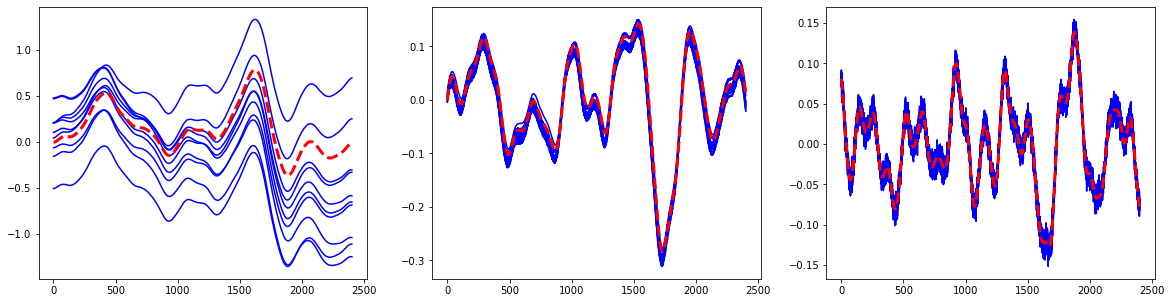

In [37]:
# plot of state space trajectories
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

for x in xb_ffbs_base:
    ax1.plot(x[:,0,0], '-b')
    ax2.plot(x[:,1,0], '-b')
    ax3.plot(x[:,2,0], '-b')

ax1.plot(x21,'--r', linewidth=3)
ax2.plot(x22,'--r', linewidth=3)
ax3.plot(x23,'--r', linewidth=3)

plt.show()

For this simple covariance-model, it appears that the chain exhibits immediate steady-state behaviour.

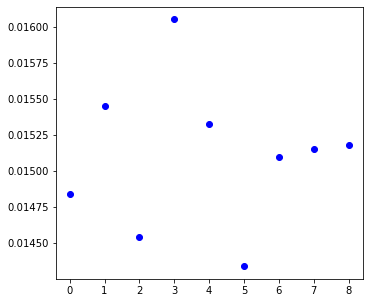

In [38]:
# plot of parameter realizations
plt.figure(figsize=(5.5,5))
plt.plot(np.array(para_ffbs_base)[1:], 'ob')
plt.show()

#### Posterior sampling under the d-inverse Gamma (DIG) model

In [39]:
np.random.seed(1)
xb_ffbs_dig, para_ffbs_dig = myPosSamplerDIG(y=y2.reshape(-1,1), cQ=cQinit, cR=np.array([sig_noise2]).reshape(-1,1), 
                                             mu0 = mu02, Sigma0 = Sigma02, A = A, Phi = Phi, Nsamp=10)

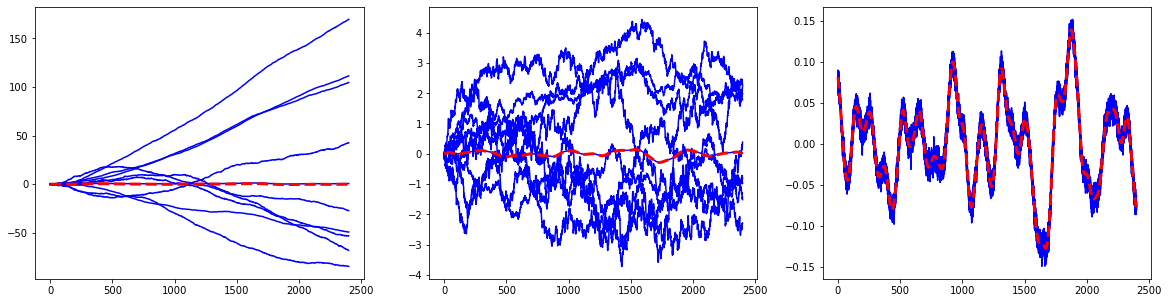

In [40]:
# plot of state space trajectories
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

for x in xb_ffbs_dig:
    ax1.plot(x[:,0,0], '-b')
    ax2.plot(x[:,1,0], '-b')
    ax3.plot(x[:,2,0], '-b')

ax1.plot(x21,'--r', linewidth=3)
ax2.plot(x22,'--r', linewidth=3)
ax3.plot(x23,'--r', linewidth=3)

plt.show()

As the model becomes more flexible, we see a large set of possible models for velocity and especially displacement that can explain the observations (accelerations). Thus, we observe large uncertainty in the model specification, which is also reflected in the parameter realizations below. Note that for a full/real application, you will have to run the chain until convergence in the parameter realizations.

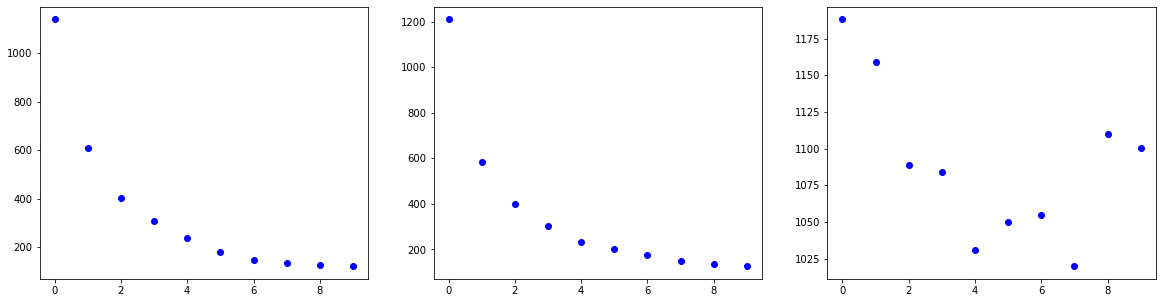

In [41]:
# plot of parameter realizations
para_ffbs_dig_mat = np.array(para_ffbs_dig)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
ax1.plot(para_ffbs_dig_mat[:,0], 'ob')
ax2.plot(para_ffbs_dig_mat[:,1], 'ob')
ax3.plot(para_ffbs_dig_mat[:,2], 'ob')
plt.show()